In [9]:
import pandas as pd
import os, sys
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib import rc
import numpy as np

In [10]:
# Inputfolder & files
inputfolder = f"../Data"

# Clean version of load data

## Nakamura dataset

In [11]:
sismic_events = ["_dm_", "_sm_", "_ai_", "_m_"]

In [12]:
nakamura_files = os.listdir(f"../Data")
nakamura_files = [file for file in nakamura_files if "nakamura" in file]
nakamura_files_per_event = {}

for event in sismic_events: nakamura_files_per_event[event[1:-1]] = [file for file in nakamura_files if event in file]
nakamura_files_per_event

{'dm': ['nakamura_2005_dm_locations.csv', 'nakamura_2005_dm_arrivals.csv'],
 'sm': ['nakamura_1983_sm_arrivals.csv', 'nakamura_1979_sm_locations.csv'],
 'ai': ['nakamura_1983_ai_locations.csv', 'nakamura_1983_ai_arrivals.csv'],
 'm': ['nakamura_1983_m_arrivals.csv']}

In [13]:
possible_type_indexes = ["A", "AI"]
for event in nakamura_files_per_event.keys():
	print(event)
	arrivals_file = [file for file in nakamura_files_per_event[event] if "arrivals" in file]
	if len(arrivals_file) != 0: arrivals = pd.read_csv(f"{inputfolder}/{arrivals_file[0]}", index_col=0)
	else: continue
 
	locations_file = [file for file in nakamura_files_per_event[event] if "locations" in file]
	if len(locations_file) != 0: locations = pd.read_csv(f"{inputfolder}/{locations_file[0]}", index_col=0)
	else: continue
	locations["Type"] = event
 
	if (not arrivals.index.name == "A") and (not arrivals.index.name == "AI"):
		locations = locations.reset_index()
		arrivals = arrivals.reset_index()
		locations_arrivals = locations.merge(arrivals, on=["Year", "Day"], how="outer")
		locations_arrivals.to_csv(f"{inputfolder}/nakamura_locations_arrivals_{event}.csv", index=False)
		locations_arrivals
  
	for index in possible_type_indexes:
		if index == arrivals.index.name: 
			locations_arrivals = locations.merge(arrivals, on=index, how="outer")
			locations_arrivals.to_csv(f"{inputfolder}/nakamura_locations_arrivals_{event}.csv", index=False)	

dm
sm
ai
m


# Heatmap based on moonquake depth - Lognonné et al. (2003)

In [14]:
def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return r, g, b

In [15]:
rgbvalue = rgb(0, 1200, 10)
rgbvalue

(0, 5, 250)

## Process dataframe

In [16]:
lognonne_df = pd.read_csv(f"{inputfolder}/lognonne_2003_catalog.csv")
new_columns = ["Year", "Month", "Day", "Hour", "Minute", "R", "G", "B"]

# New columns for Date & RGB
for column in new_columns: lognonne_df[column]=0

# RGB scale based on moonquake depth
min_depth = lognonne_df["Depth"].min()
max_depth = lognonne_df["Depth"].max()

# Process Date column & RGB column
for row in lognonne_df.itertuples():
	index = row[0]
	depth = lognonne_df.loc[index, "Depth"]
 
	# Date column into Year, Month, etc.
	lognonne_df.loc[index, "Year"] = str(19)+str(lognonne_df.loc[index, "Date"])[0:2]
	lognonne_df.loc[index, "Month"] = str(lognonne_df.loc[index, "Date"])[2:4]
	lognonne_df.loc[index, "Day"] = str(lognonne_df.loc[index, "Date"])[4:6]
	lognonne_df.loc[index, "Hour"] = str(lognonne_df.loc[index, "Date"])[6:8]
	lognonne_df.loc[index, "Minute"] = str(lognonne_df.loc[index, "Date"])[8:]

	# RGB colour scale
	lognonne_df.loc[index, "R"], lognonne_df.loc[index, "G"], lognonne_df.loc[index, "B"] = rgb(min_depth, max_depth, depth)

lognonne_df=lognonne_df.drop(["Date"], axis=1)  # unneeded column

# transfoorm Lat, Long to radians
lognonne_df["Latrad"] = lognonne_df["Lat"]*(np.pi/180)
lognonne_df["Longrad"] = lognonne_df["Long"]*(np.pi/180)

# compute new coordinates over spherical Moon representation
sphere_radius = 10
lognonne_df["zpos"]= sphere_radius * np.cos(lognonne_df["Latrad"]) * np.cos(lognonne_df["Longrad"])
lognonne_df["ypos"]= sphere_radius * np.sin(lognonne_df["Latrad"])
lognonne_df["xps"]= -sphere_radius * np.cos(lognonne_df["Latrad"]) * np.sin(lognonne_df["Longrad"])

## 2D heatmap

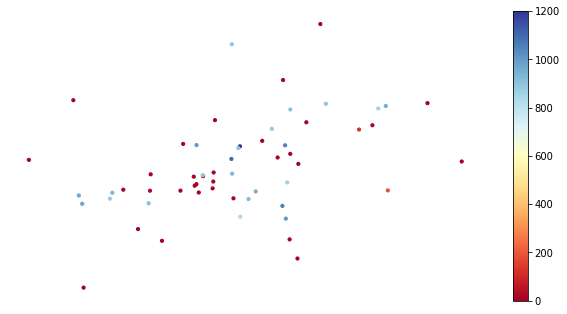

In [17]:
mydpi=96
transparent=False
cm = plt.cm.get_cmap('RdYlBu')
fit_scatter = plt.figure(num=0, clear=True, figsize=(1024/mydpi, 512/mydpi))
sc = plt.scatter(lognonne_df.Lat, lognonne_df.Long, s=10, c=lognonne_df.Depth, cmap=cm)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
plt.axis('off')  # command for hiding the axis
fit_scatter.savefig("../images/moon_heatmap.png", transparent=transparent, dpi=mydpi)
plt.colorbar(sc)
# plt.close(fit_scatter)

## Save dataframe

In [18]:
recompute = True
if not os.path.exists(f"{inputfolder}/lognonne_2003_catalog_adapted.csv") or recompute:
    lognonne_df.to_csv(f"{inputfolder}/lognonne_2003_catalog_adapted.csv", index=False)